# Evaluate the SWPP Wind Forecast Fidelity During the June 2023 Lull Event


In [1]:
# Start by importing the packages we need:
import os
import glob
import datetime

import pandas as pd
import matplotlib.pyplot as plt


## Set the Directory Structure


In [15]:
# Identify the data input and image output directories:
data_input_dir =  '/Users/burl878/Documents/Code/code_repos/spp_wind_forecast/data/'
image_output_dir =  '/Users/burl878/Documents/Code/code_repos/spp_wind_forecast/plots/'


## Format the Forecast Data


In [3]:
# Read in the .csv file and replace missing values with nan:
forecast_df = pd.read_csv((data_input_dir + '20230531_Forecast.csv'))

# Rename the a few variables for simplicity:
forecast_df.rename(columns={'STLF': 'ST_Load_MWh',
                            'MTLF': 'MT_Load_MWh',
                            'STWF': 'ST_Wind_MWh',
                            'MTWF': 'MT_Wind_MWh'}, inplace=True)

# Convert the time to a datetime variable:
forecast_df['Time_UTC'] = pd.to_datetime(forecast_df['GMTIntervalEnd'])

# Only keep the columns that are needed:
forecast_df = forecast_df[['Time_UTC', 'ST_Load_MWh', 'MT_Load_MWh', 'ST_Wind_MWh', 'MT_Wind_MWh']].copy()

# Drop rows with missing values:
forecast_df = forecast_df.dropna(thresh=2)

# Return the formatted dataframe:
forecast_df


,Time_UTC,ST_Load_MWh,MT_Load_MWh,ST_Wind_MWh,MT_Wind_MWh
9,2023-06-07 21:00:00,NaN,39373.901,NaN,3336.00
21,2023-06-07 20:00:00,NaN,38621.401,NaN,3173.52
33,2023-06-07 19:00:00,NaN,37613.888,NaN,2998.83
45,2023-06-07 18:00:00,NaN,36114.435,NaN,2793.63
57,2023-06-07 17:00:00,NaN,34557.580,NaN,2623.93
...,...,...,...,...,...
2299,2023-05-30 22:10:00,40877.191,NaN,6951.26,NaN
2300,2023-05-30 22:05:00,40868.415,NaN,6792.71,NaN
2301,2023-05-30 22:00:00,40856.254,40768.896,6746.81,7077.82
2302,2023-05-30 21:55:00,40865.289,NaN,6812.30,NaN


## Format the Observed Data


In [4]:
# Read in the data from the EIA-930 Excel file:
obs_df = pd.read_excel((data_input_dir + '20230609_EIA930.xlsx'), sheet_name='Data')

# Convert the time to a datetime variable:
obs_df['Time_UTC'] = pd.to_datetime(obs_df['UTC time'])

# Rename the a few variables for simplicity:
obs_df.rename(columns={'D': 'Obs_Load_MWh',
                       'NG: WND': 'Obs_Wind_MWh'}, inplace=True)

# Only keep the columns that are needed:
obs_df = obs_df[['Time_UTC', 'Obs_Load_MWh', 'Obs_Wind_MWh']].copy()

# Return the formatted dataframe:
obs_df


,Time_UTC,Obs_Load_MWh,Obs_Wind_MWh
0,2023-05-30 00:00:00,35521,5892
1,2023-05-30 01:00:00,34682,6774
2,2023-05-30 02:00:00,33580,9394
3,2023-05-30 03:00:00,32693,12164
4,2023-05-30 04:00:00,30831,14299
...,...,...,...
241,2023-06-09 01:00:00,39598,2364
242,2023-06-09 02:00:00,37875,2681
243,2023-06-09 03:00:00,36499,3283
244,2023-06-09 04:00:00,34241,4399


## Merge the Forecast and Observed Data Together


In [49]:
# Merge the two dataframes together based on common UTC times:
merged_df = forecast_df.merge(obs_df, on=['Time_UTC'])

# Calculate the errors:
merged_df['ST_Load_Error_MWh'] = (merged_df['Obs_Load_MWh'] - merged_df['ST_Load_MWh']).round(2)
merged_df['MT_Load_Error_MWh'] = (merged_df['Obs_Load_MWh'] - merged_df['MT_Load_MWh']).round(2)
merged_df['ST_Wind_Error_MWh'] = (merged_df['Obs_Wind_MWh'] - merged_df['ST_Wind_MWh']).round(2)
merged_df['MT_Wind_Error_MWh'] = (merged_df['Obs_Wind_MWh'] - merged_df['MT_Wind_MWh']).round(2)

# Calculate the solar capacity factor based on an installed capacity of 32,000 MW:
merged_df['Wind_CF'] = (merged_df['Obs_Wind_MWh'] / 32000)

merged_df


,Time_UTC,ST_Load_MWh,MT_Load_MWh,ST_Wind_MWh,MT_Wind_MWh,Obs_Load_MWh,Obs_Wind_MWh,ST_Load_Error_MWh,MT_Load_Error_MWh,ST_Wind_Error_MWh,MT_Wind_Error_MWh,Wind_CF
0,2023-06-07 21:00:00,NaN,39373.901,NaN,3336.00,42602,2576,NaN,3228.10,NaN,-760.00,0.080500
1,2023-06-07 20:00:00,NaN,38621.401,NaN,3173.52,41678,1423,NaN,3056.60,NaN,-1750.52,0.044469
2,2023-06-07 19:00:00,NaN,37613.888,NaN,2998.83,40399,797,NaN,2785.11,NaN,-2201.83,0.024906
3,2023-06-07 18:00:00,NaN,36114.435,NaN,2793.63,38785,593,NaN,2670.57,NaN,-2200.63,0.018531
4,2023-06-07 17:00:00,NaN,34557.580,NaN,2623.93,36784,529,NaN,2226.42,NaN,-2094.93,0.016531
...,...,...,...,...,...,...,...,...,...,...,...,...
187,2023-05-31 02:00:00,36161.368,36797.324,13179.01,11459.38,36654,12109,492.63,-143.32,-1070.01,649.62,0.378406
188,2023-05-31 01:00:00,37492.823,38349.377,10733.92,10622.33,38299,10579,806.18,-50.38,-154.92,-43.33,0.330594
189,2023-05-31 00:00:00,39168.834,39910.145,9891.59,9093.07,39758,9520,589.17,-152.14,-371.59,426.93,0.297500
190,2023-05-30 23:00:00,40352.520,40503.392,8300.92,7210.82,40668,7679,315.48,164.61,-621.92,468.18,0.239969


## Read in the Historical Capacity Factor Dataset


In [44]:
cf_df =  pd.read_csv((os.path.join(data_input_dir, ('SWPP_Historical_Capacity_Factors.csv'))))

cf_df


,ba,datetime_utc,wind_cf,solar_cf
0,SWPP,1980-01-01T06:00:00Z,0.191480,0.000000
1,SWPP,1980-01-01T07:00:00Z,0.214085,0.000000
2,SWPP,1980-01-01T08:00:00Z,0.255081,0.000000
3,SWPP,1980-01-01T09:00:00Z,0.238016,0.000000
4,SWPP,1980-01-01T10:00:00Z,0.231977,0.000000
...,...,...,...,...
350629,SWPP,2019-12-31T19:00:00Z,0.225651,0.673380
350630,SWPP,2019-12-31T20:00:00Z,0.226881,0.651969
350631,SWPP,2019-12-31T21:00:00Z,0.243062,0.536789
350632,SWPP,2019-12-31T22:00:00Z,0.272008,0.287331


## Make the Time Series and Error Distribution Plots


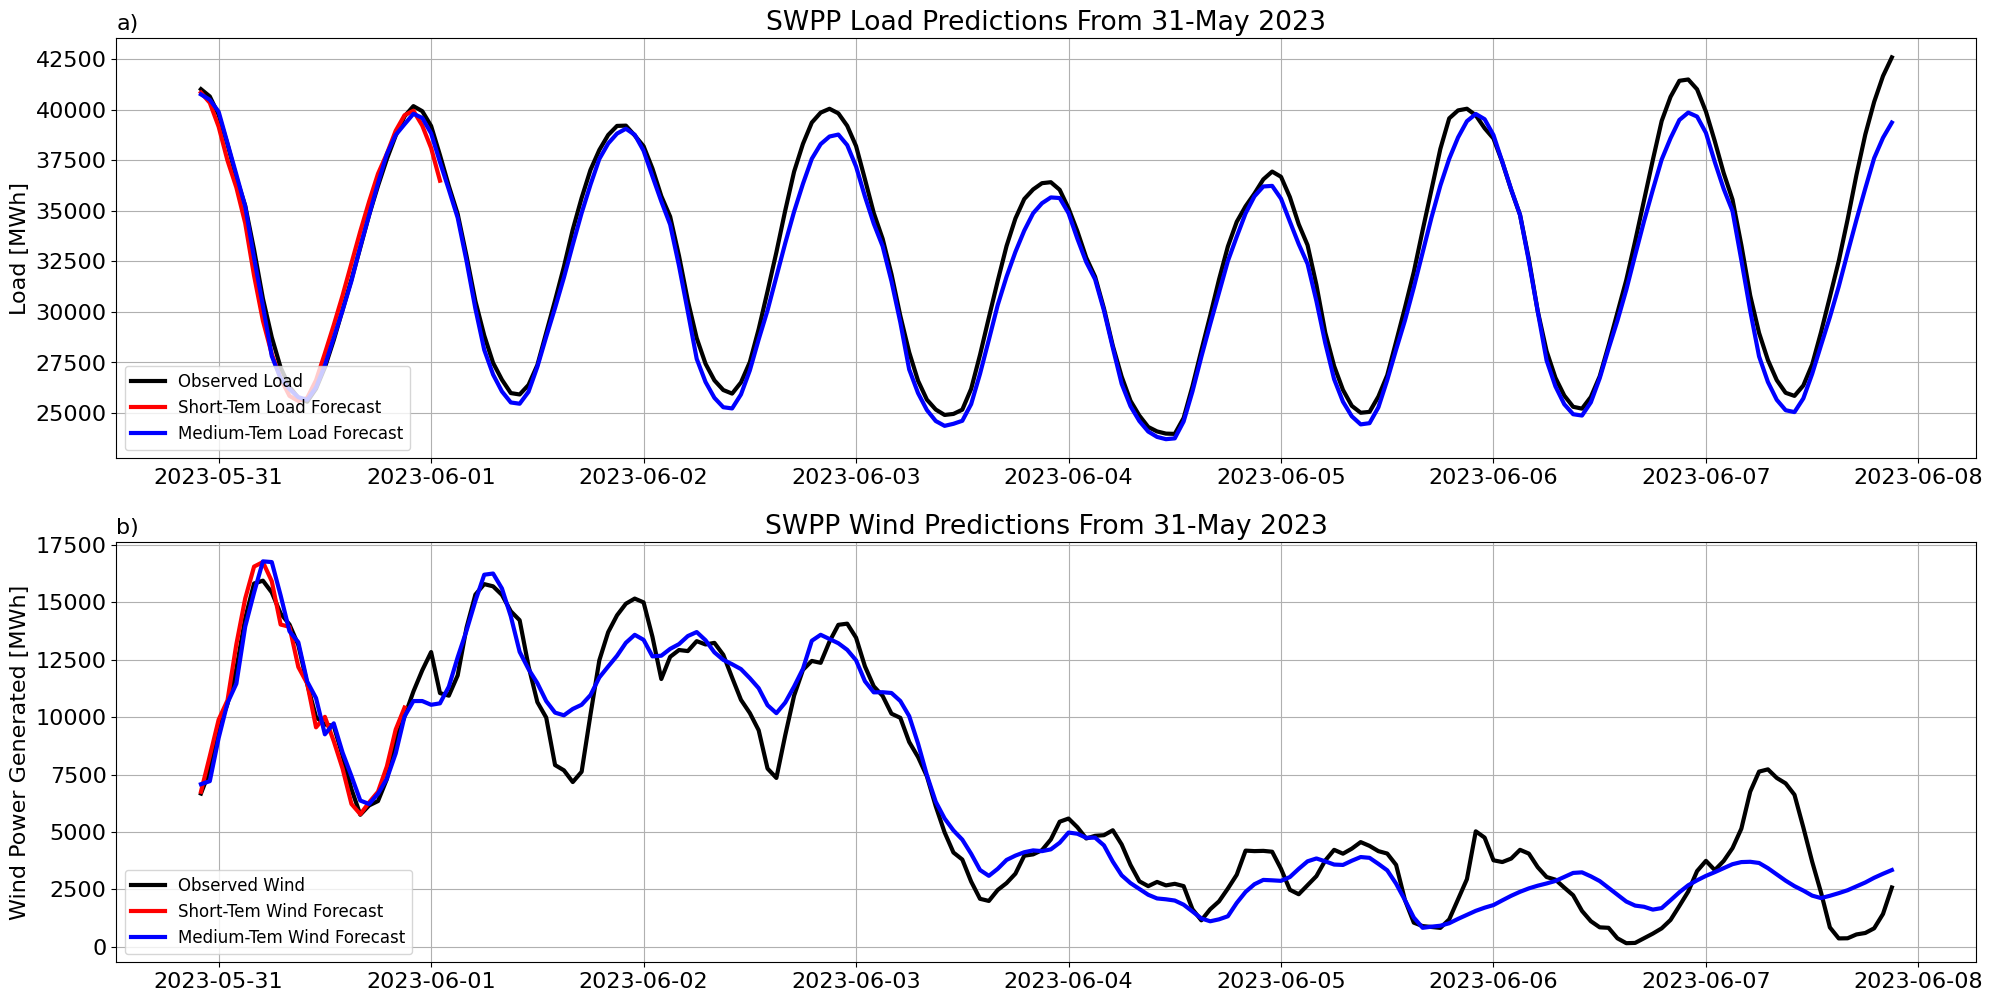

In [16]:
# Make the time series plot:
plt.figure(figsize=(24, 12))
plt.rcParams['font.size'] = 16
    
plt.subplot(211)
plt.plot(merged_df['Time_UTC'], merged_df['Obs_Load_MWh'], color='black', linestyle='-', label='Observed Load', linewidth=3)
plt.plot(merged_df['Time_UTC'], merged_df['ST_Load_MWh'], color='red', linestyle='-', label='Short-Tem Load Forecast', linewidth=3)
plt.plot(merged_df['Time_UTC'], merged_df['MT_Load_MWh'], color='blue', linestyle='-', label='Medium-Tem Load Forecast', linewidth=3)
plt.legend(loc='lower left', prop={'size': 12})
plt.ylabel('Load [MWh]')
plt.grid(True)
plt.title('a)', loc='left', fontsize=16)
plt.title(('SWPP Load Predictions From 31-May 2023'))

plt.subplot(212)
plt.plot(merged_df['Time_UTC'], merged_df['Obs_Wind_MWh'], color='black', linestyle='-', label='Observed Wind', linewidth=3)
plt.plot(merged_df['Time_UTC'], merged_df['ST_Wind_MWh'], color='red', linestyle='-', label='Short-Tem Wind Forecast', linewidth=3)
plt.plot(merged_df['Time_UTC'], merged_df['MT_Wind_MWh'], color='blue', linestyle='-', label='Medium-Tem Wind Forecast', linewidth=3)
plt.legend(loc='lower left', prop={'size': 12})
plt.ylabel('Wind Power Generated [MWh]')
plt.grid(True)
plt.title('b)', loc='left', fontsize=16)
plt.title(('SWPP Wind Predictions From 31-May 2023'))

# Save the figure:
plt.savefig(os.path.join(image_output_dir, 'Wind_and_Load_Time_Series.png'), dpi=300, bbox_inches='tight', facecolor='white')


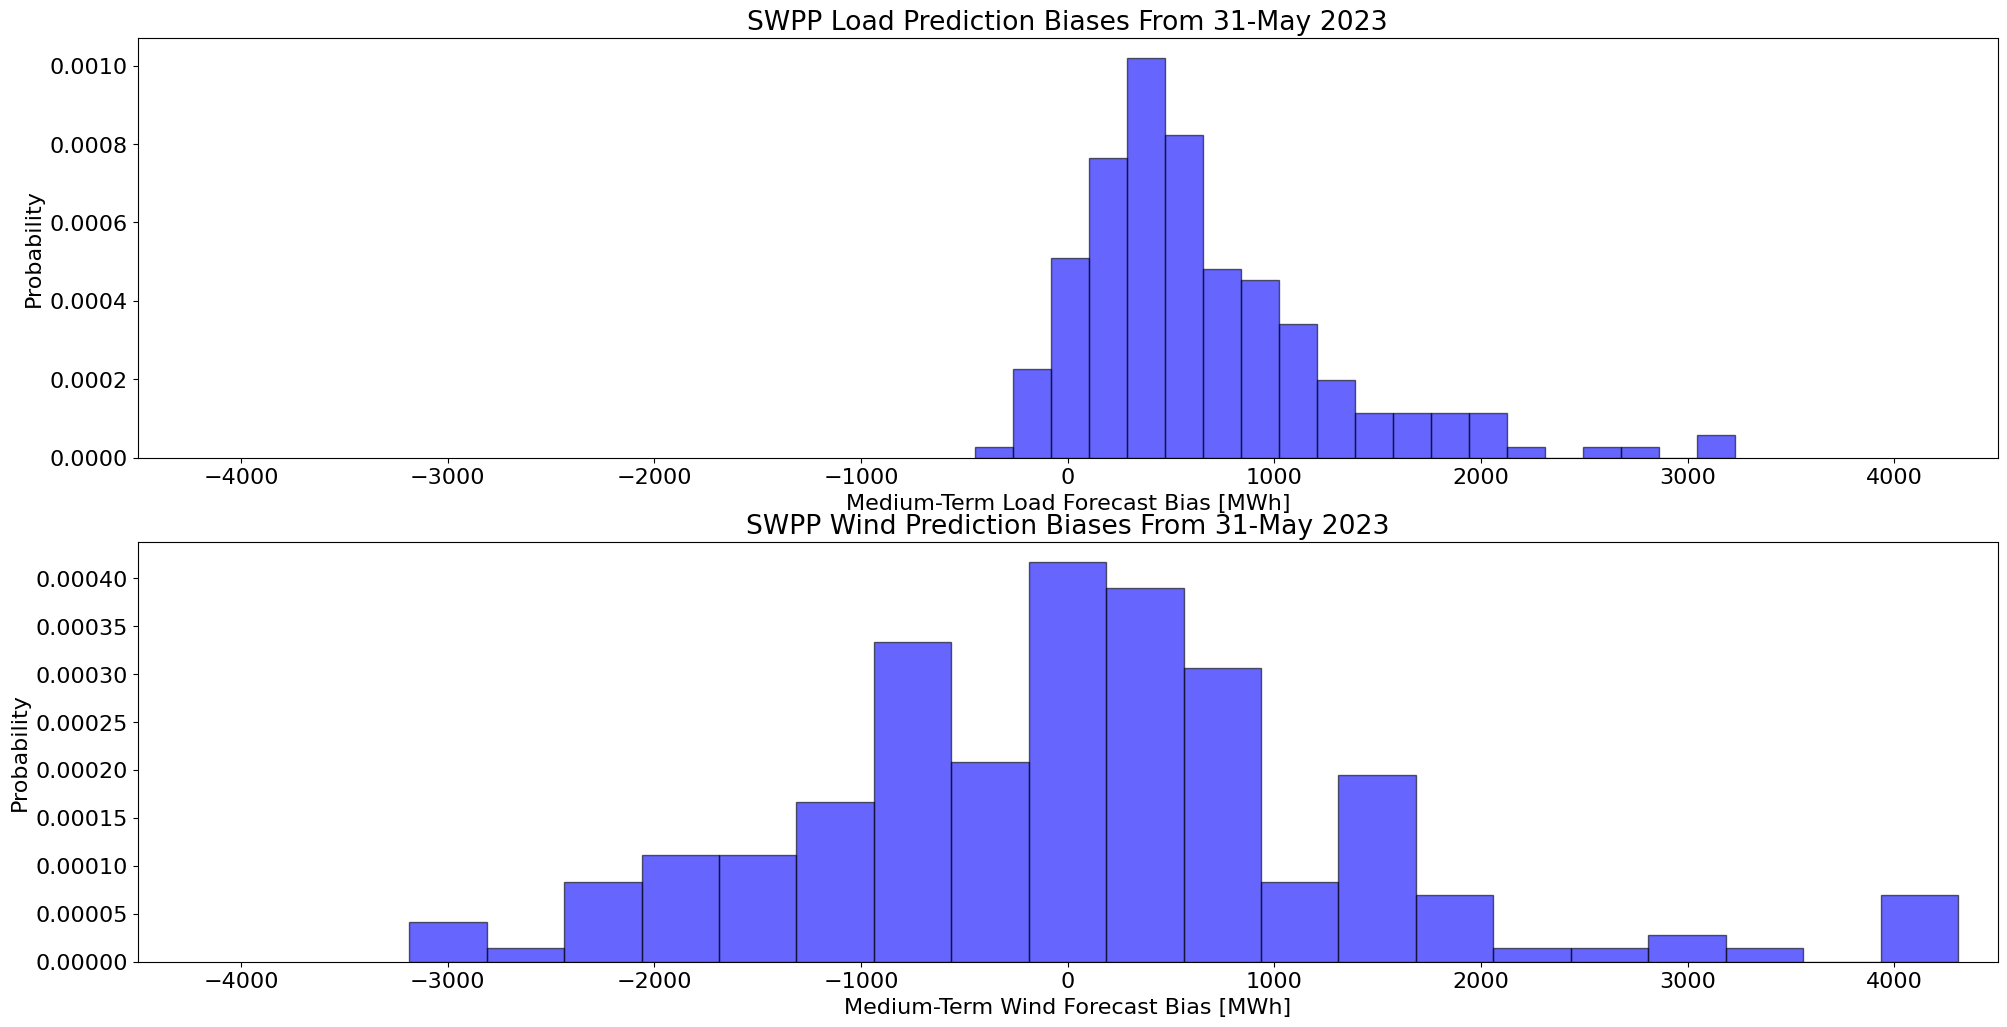

In [29]:
# Make the error distribution plot:
plt.figure(figsize=(24, 12))
plt.rcParams['font.size'] = 16

plt.subplot(211)
n, bins, patches = plt.hist(merged_df['MT_Load_Error_MWh'], 20, density=True, facecolor='b', edgecolor='black', alpha=0.6, label='Histogram')
plt.xlim(-4500, 4500)
plt.xlabel('Medium-Term Load Forecast Bias [MWh]')
plt.ylabel('Probability')
plt.title('SWPP Load Prediction Biases From 31-May 2023')

plt.subplot(212)
n, bins, patches = plt.hist(merged_df['MT_Wind_Error_MWh'], 20, density=True, facecolor='b', edgecolor='black', alpha=0.6, label='Histogram')
plt.xlim(-4500, 4500)
plt.xlabel('Medium-Term Wind Forecast Bias [MWh]')
plt.ylabel('Probability')
plt.title('SWPP Wind Prediction Biases From 31-May 2023')

# Save the figure:
plt.savefig(os.path.join(image_output_dir, 'Bias_Distributions.png'), dpi=300, bbox_inches='tight', facecolor='white')


Text(0.5, 1.0, 'Observed SWPP Wind Capacity Factor from 31-May to 7-Jun 2023')

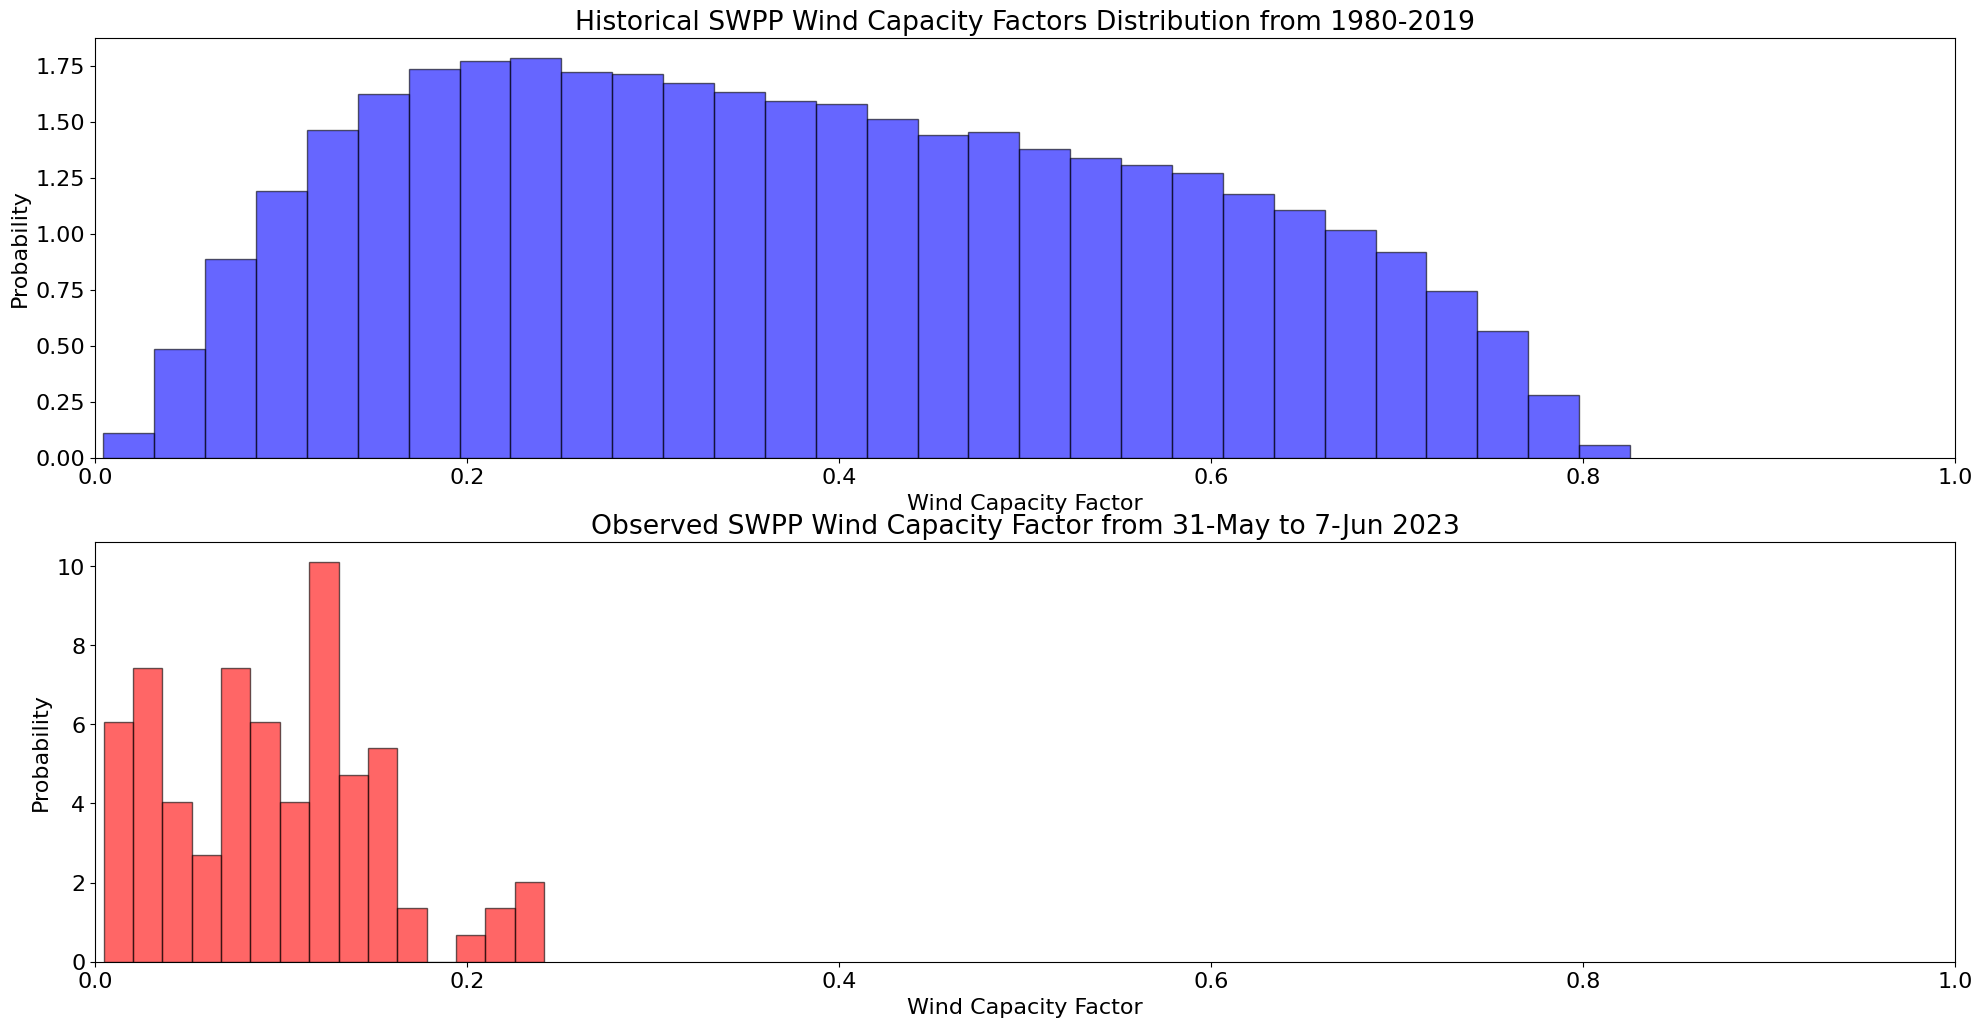

In [57]:
# Subset to just the period of interest:
subset_df = merged_df.loc[merged_df['Time_UTC'] >= pd.to_datetime('2023-06-04 00:00:00')].copy()

# Make the wind capacity factor distribution plot:
plt.figure(figsize=(24, 12))
plt.rcParams['font.size'] = 16

plt.subplot(211)
n, bins, patches = plt.hist(cf_df['wind_cf'], 30, density=True, facecolor='b', edgecolor='black', alpha=0.6, label='Historical Distribution')
plt.xlim(0, 1)
plt.xlabel('Wind Capacity Factor')
plt.ylabel('Probability')
plt.title('Historical SWPP Wind Capacity Factors Distribution from 1980-2019')

plt.subplot(212)
n, bins, patches = plt.hist(subset_df['Wind_CF'], 15, density=True, facecolor='r', edgecolor='black', alpha=0.6, label='Distribution 31-May to 7-Jun')
plt.xlim(0, 1)
plt.xlabel('Wind Capacity Factor')
plt.ylabel('Probability')
plt.title('Observed SWPP Wind Capacity Factor from 4-Jun to 7-Jun 2023')
